# Soft Sorting

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main
    !pip install -q requests
!pip install torchvision

In [2]:
import functools
import io
from typing import Any
import collections

import requests

import flax
import optax
import flax.linen as nn
import jax
import jax.numpy as jnp
from flax.training import common_utils
import numpy as np
import scipy.ndimage
import torchvision
from torch.utils import data

import matplotlib.pyplot as plt

import ott

## Sorting operators

Given an array of $n$ numbers, several operators arise around the idea of sorting:

- The soft {func}`~ott.tools.soft_sort.sort` operator reshuffles the values in order, from smallest to largest.
- The soft {func}`~ott.tools.soft_sort.ranks` operator associates to each value its rank, when sorting in ascending order.
- The soft {func}`~ott.tools.soft_sort.quantile` operator consider a `level` value between 0 and 1, to return the element of the sorted array indexed at `int(n * level)`, the median for instance if that level is set to $0.5$.
- The `top-k` operator is equivalent to the {func}`~ott.tools.soft_sort.sort` operator, but only returns the
largest $k$ values, namely the last $k$ values of the sorted vector.

Here are some examples

In [3]:
x = jnp.array([1.0, 5.0, 4.0, 8.0, 12.0])
jnp.sort(x)

Array([ 1.,  4.,  5.,  8., 12.], dtype=float32)

In [4]:
def rank(x):
    return jnp.argsort(jnp.argsort(x))


rank(x)

Array([0, 2, 1, 3, 4], dtype=int32)

In [5]:
jnp.quantile(x, 0.5)

Array(5., dtype=float32)

## Soft operators

Sorting operators are ubiquitous in CS and stats, but have several limitations when used in modern deep learning architectures. For instance, `ranks` is integer valued: if used at some point within a DL pipeline, one won't be able to differentiate through that step because the gradient of these integer values does not exist, or is ill-defined. Indeed, the vector of `ranks` of a slightly perturbed vector $x+\Delta x$ is the same as that for $x$, or switches ranks at some indices when inversions occur. Practially speaking, any loss or intermediary operation based on `ranks` will break backpropagation.

This colab shows how *soft* counterparts to these operators are defined in OTT. By *soft*, we mean **differentiable**, **approximate** proxies to these original _"hard"_ operators. For instance, soft {func}`~ott.tools.soft_sort.ranks` returned by OTT operators won't be integer valued, but instead floating point approximations; soft {func}`~ott.tools.soft_sort.sort` will not contain exactly the $n$ values contained in the input array, reordered, but instead $n$ combinations of thoses values that look very close to them.

**These soft operators trade off accuracy for a more informative Jacobian**. This trade-off is controlled by a non-negative parameter `epsilon`: The *smaller* `epsilon`, the closer to the original ranking and sorting operations; The *bigger*, the more bias yet the more informative gradients. That `epsilon` also correponds to that used in regularized OT, see {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` documentation for more.

The behavior of these operators is illustrated below.

### Soft sort

In [6]:
softsort = jax.jit(ott.tools.soft_sort.sort)
print(softsort(x))

[ 1.0504104  4.122876   4.8620253  8.006994  11.957698 ]


As we can see, the values are close to the original ones but not exactly equal. Here, `epsilon` is set by default to `1e-2`. A smaller `epsilon` reduces that gap, whereas a bigger one would tend to squash all returned values to the **average** of the input values.

In [7]:
print(softsort(x, epsilon=1e-4))
print(softsort(x, epsilon=1e-1))

[ 0.9983629  3.9949732  5.006686   8.010008  11.9900875]
[ 2.570548   3.7336338  5.462017   8.000691  10.23311  ]


### Soft top-k

The soft operators we propose build on a common idea: formulate sorting operations as optimal transports from an array of $n$ values to a predefined target measure of $m$ points. The user is free to choose $m$, providing great flexibility depending on the use case. 

Transporting an input discrete measure of $n$ points towards one of $m$ points results in a $O(nm)$ complexity. The bigger $m$, the more fine grained quantities we recover. For instance, if we wish to get both a fine grained yet differentiable sorted vector, or vector of ranks, one can define a target measure of size $m=n$, leading to a $O(n^2)$ complexity.

On the contrary, if we are only interested in singling out a few important ranks, such as when considering `top-k` values, we can simply transport the inputs points onto $k+1$ targets, leading to a smaller complexity in $O(nk)$. When $k \ll n$, the gain in time and memory can be of course substantial.

Here is an example.

In [8]:
top5 = jax.jit(functools.partial(ott.tools.soft_sort.sort, topk=5))

# Generates a vector of size 1000
big_x = jax.random.uniform(jax.random.PRNGKey(0), (1000,))
top5(big_x)

Array([0.9506124, 0.9741584, 0.9832676, 0.9879085, 0.9905736], dtype=float32)

### Soft Ranks

Similarly, we can compute soft {func}`~ott.tools.soft_sort.ranks`, which do not output integer values, but provide instead a differentiable, float valued, approximation of the vector of ranks.

In [9]:
softranks = jax.jit(ott.tools.soft_sort.ranks)
print(softranks(x))

[0.01550213 1.8387034  1.1487265  2.9977002  3.9927652 ]


### Regularization effect

As mentioned earlier, `epsilon` controls the tradeoff between accuracy and differentiability. Larger `epsilon` tend to merge the soft {func}`~ott.tools.soft_sort.ranks` of values that are close, up to the point where they all collapse to the average rank or average value.

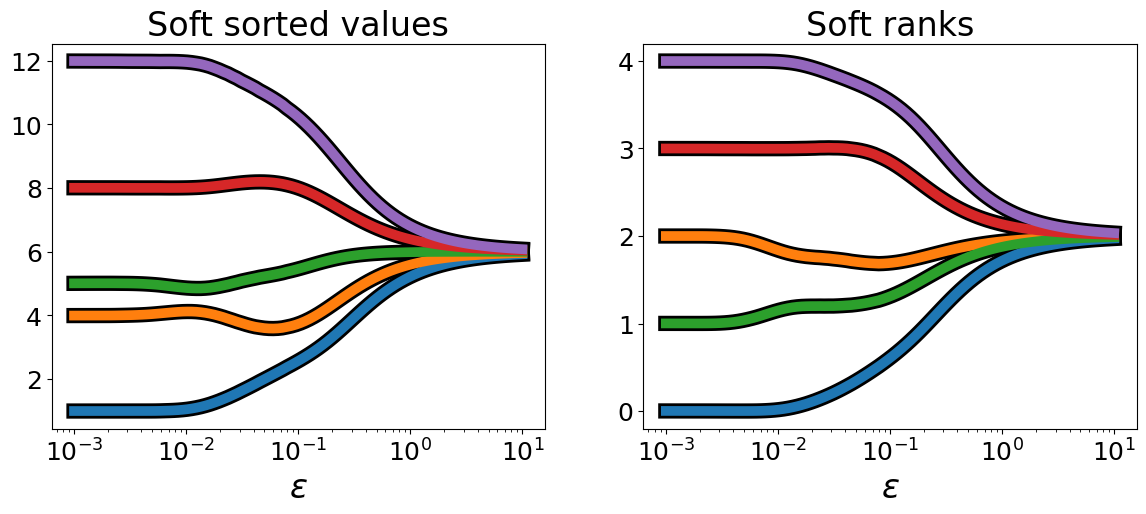

In [10]:
epsilons = np.logspace(-3, 1, 100)
sorted_values = []
ranks = []
for e in epsilons:
    sorted_values.append(softsort(x, epsilon=e))
    ranks.append(softranks(x, epsilon=e))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for values, ax, title in zip(
    (sorted_values, ranks), axes, ("sorted values", "ranks")
):
    ax.plot(epsilons, np.array(values), color="k", lw=11)
    ax.plot(epsilons, np.array(values), lw=7)
    ax.set_xlabel(r"$\epsilon$", fontsize=24)
    ax.tick_params(axis="both", which="both", labelsize=18)
    ax.set_title(f"Soft {title}", fontsize=24)
    ax.set_xscale("log")

Note how none of the lines above cross. This is a fundamental property of {func}`~ott.tools.soft_sort.sort` operators, proved in {cite}`cuturi:19`: soft sorting and ranking operators are monotonic: the vector of soft-sorted values will remain increasing for any `epsilon`, whereas if an input value $x_i$ has a smaller (hard) rank than $x_j$, its soft-rank, for any value of `epsilon`, will also remain smaller than that for $x_j$.

### Soft quantile

To illustrate further the flexibility provided by setting target measures, one can notice that when a soft {func}`~ott.tools.soft_sort.quantile` is targeted (for instance the soft median), the complexity becomes simply $O(n)$. This is illustrated below to define "soft median" differentiable filter on a noisy image.

In [11]:
softquantile = jax.jit(ott.tools.soft_sort.quantile)
softquantile(x, level=0.5)

Array([4.995728], dtype=float32)

In [12]:
url = "https://raw.githubusercontent.com/matplotlib/matplotlib/master/doc/_static/stinkbug.png"
resp = requests.get(url)
image = plt.imread(io.BytesIO(resp.content))
image = image[..., 0]

In [13]:
def salt_and_pepper(im, amount=0.05):
    result = np.copy(im)
    result = np.reshape(result, (-1,))
    num_noises = int(np.ceil(amount * im.size))
    indices = np.random.randint(0, im.size, num_noises)
    values = np.random.uniform(size=(num_noises,)) > 0.5
    result[indices] = values
    return np.reshape(result, im.shape)


noisy_image = salt_and_pepper(image, amount=0.1)

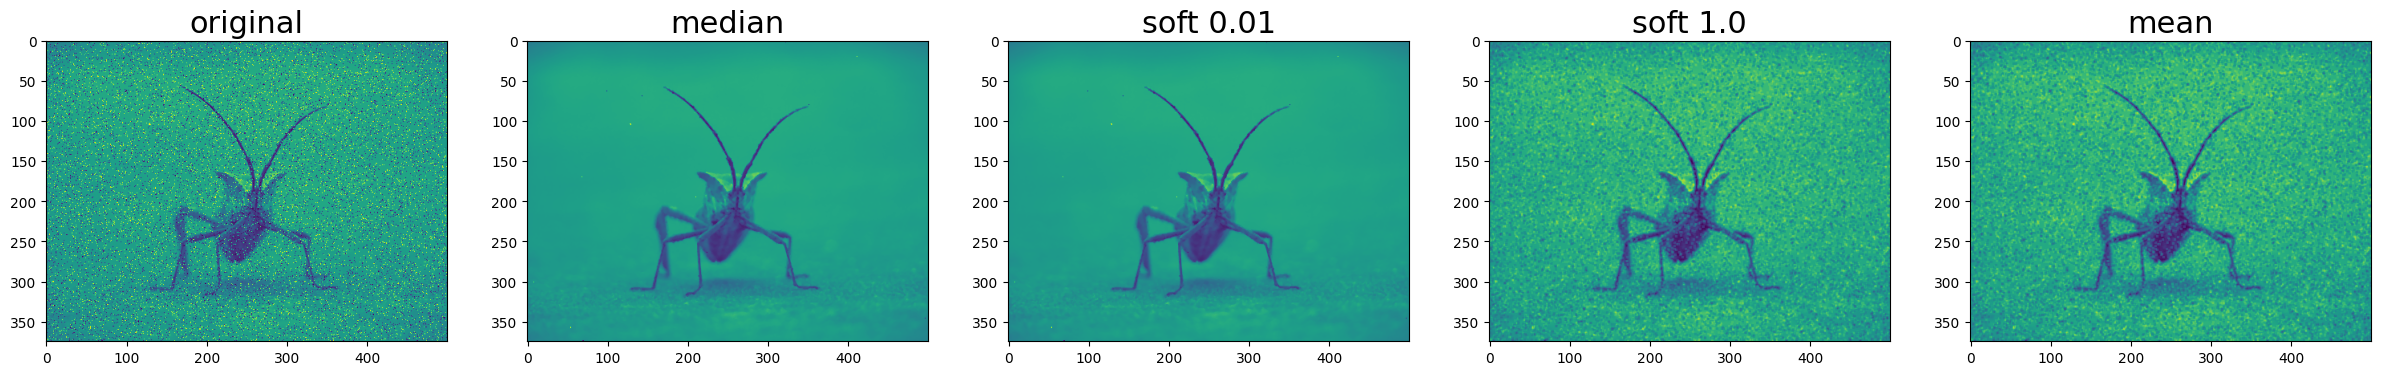

In [14]:
softmedian = jax.jit(functools.partial(ott.tools.soft_sort.quantile, level=0.5))

fns = {"original": None, "median": np.median}
for e in [0.01, 1.0]:
    fns[f"soft {e}"] = functools.partial(softmedian, epsilon=e)
fns.update(mean=np.mean)

fig, axes = plt.subplots(1, len(fns), figsize=(len(fns) * 6, 4))
for key, ax in zip(fns, axes):
    fn = fns[key]
    soft_denoised = (
        scipy.ndimage.generic_filter(noisy_image, fn, size=(3, 3))
        if fn is not None
        else noisy_image
    )
    ax.imshow(soft_denoised)
    ax.set_title(key, fontsize=22)

## Learning through a soft ranks operator.

A crucial feature of OTT lies in the ability it provides to **differentiate** seamlessly through any quantities that follow an optimal transport computation, making it very easy for end-users to plug them directly into end-to-end differentiable architectures. 

In this tutorial we show how OTT can be used to implement a loss based on soft {func}`~ott.tools.soft_sort.ranks`. That soft 0-1 loss is used here to train a neural network for image classification, as done by {cite}`cuturi:19`.

This implementation relies on [Flax](https://github.com/google/flax) and [optax](https://github.com/deepmind/optax) libraries for creating and training neural networks with JAX. We also use pytorch dataset and dataloaders.

### Model

We will train a vanilla CNN, in order to classify images from the MNIST dataset.

In [15]:
class ConvBlock(nn.Module):
    """A simple CNN block."""

    features: int = 32
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x, train: bool = True):
        x = nn.Conv(features=self.features, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        return x


class CNN(nn.Module):
    """A simple CNN model."""

    num_classes: int = 10
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x, train: bool = True):
        x = ConvBlock(features=8)(x)
        x = ConvBlock(features=8)(x)
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=392)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.num_classes)(x)
        return x

In [16]:
def initialized(key, height, width, model):
    """Initialize the model parameters."""
    input_shape = (1, height, width, 1)

    @jax.jit
    def init(*args):
        return model.init(*args)

    variables = init({'params': key}, jnp.ones(input_shape, jnp.float32))
    model_state, params = variables.pop('params')
    return params, model_state



### Losses & Metrics

The $0/1$ loss of a classifier on a labeled example is $0$ if the logit of the true class ranks on top (here, would have rank 9, since MNIST considers 10 classes). Of course the $0/1$ loss is non-differentiable, which is one reason we usually rely on the cross-entropy loss instead.

Here, as in {cite}`cuturi:19`, we consider a differentiable "soft" 0/1 loss by measuring the gap between the soft {func}`~ott.tools.soft_sort.ranks` of the logit of the right answer and the target rank, 9. If that gap is bigger than 0, then we incurr a loss equal to that gap.

In [17]:
def cross_entropy_loss(logits, labels):
    logits = nn.log_softmax(logits)
    return -jnp.sum(labels * logits) / labels.shape[0]


def soft_error_loss(logits, labels):
    """The average distance between the best rank and the rank of the true class."""
    ranks_fn = jax.jit(functools.partial(ott.tools.soft_sort.ranks, axis=-1))
    soft_ranks = ranks_fn(logits)
    return jnp.mean(
        nn.relu(labels.shape[-1] - 1 - jnp.sum(labels * soft_ranks, axis=1))
    )

In [18]:
def compute_metrics(logits, labels, loss_fn):
    loss = loss_fn(logits, labels)
    ce = cross_entropy_loss(logits, labels)
    accuracy = jnp.argmax(logits, -1) == jnp.argmax(labels, -1)
    return {
        'loss': jnp.mean(loss),
        'cross_entropy': jnp.mean(ce),
        'accuracy': jnp.mean(accuracy),
    }


Some functions to log training errors.

In [19]:
@flax.struct.dataclass
class TrainState:
    step: int
    opt_state: Any 
    model_state: Any
    params: Any


def create_train_state(rng, config, model, height, width):
    """Create initial training state."""
    params, model_state = initialized(rng, height, width, model)
    opt_state = config.optimizer.init(params) 
    state = TrainState(step=0, opt_state=opt_state, model_state=model_state, params=params)
    return state


def log(results, step, summary, train=True):
    """Log the metrics to stderr and tensorboard."""

    phase = 'train' if train else 'eval'
    for key in ('loss', 'cross_entropy', 'accuracy'):
        results[f'{phase}_{key}'].append((step + 1, summary[key]))
    print('{} step: {}, loss: {:.3f}, cross entropy: {:.3f}, accuracy: {:.2%}'.format(phase, step, 
                                                                                       summary['loss'],
                                                                                       summary['cross_entropy'],
                                                                                       summary['accuracy']))

Some helpers to manage the CIFAR10 dataset.

To know more about training a neural network with Flax, please refer to the [Flax Imagenet examples](https://github.com/google/flax/tree/main/examples/imagenet). After 100 updates through the MNIST training examples, we are able to classify digits successfuly, similar to what is done in {cite}`cuturi:19` on CIFAR-10. We see that a soft $0/1$ error loss, building on top of soft {func}`~ott.tools.soft_sort.ranks`, can provide a competitive alternative to the cross entropy loss for classification tasks. As mentioned in that paper, that loss is less prone to overfitting. 

In [20]:
class NameSpace():
    def __init__(self):
        return

In [28]:

def train_step(apply_fn, loss_fn, optimizer, state, batch):
    """Perform a single training step."""

    def compute_loss(params):
        variables = {'params': params, **state.model_state}
        logits = apply_fn(variables, batch['image'])
        loss = loss_fn(logits, batch['label'])
        return loss, logits

    (loss, logits), grads = jax.value_and_grad(compute_loss, has_aux=True)(state.params)
    updates, new_opt_state = optimizer.update(grads, state.opt_state, state.params)
    new_params = optax.apply_updates(state.params, updates)
    metrics = compute_metrics(logits, batch['label'], loss_fn=loss_fn)
    new_state = state.replace(step=state.step + 1, opt_state=new_opt_state, params=new_params)
    return new_state, metrics


def eval_step(apply_fn, loss_fn, state, batch):
    params = state.params
    variables = {'params': params, **state.model_state}
    logits = apply_fn(variables, batch['image'], train=False, mutable=False)
    return compute_metrics(logits, batch['label'], loss_fn=loss_fn)




def train_and_evaluate(state, rng, config: NameSpace):
    """Execute model training and evaluation loop."""

    loss_fn = config.loss
    
    train_iter = data.DataLoader(config.train_dataset, batch_size=config.batch_size, shuffle=True)
    eval_iter = data.DataLoader(config.eval_dataset, batch_size=config.batch_size)

    v_train_step = (functools.partial(train_step, model.apply, loss_fn, config.optimizer, ))
    v_eval_step = (functools.partial(eval_step, model.apply, loss_fn))

    results = collections.defaultdict(list)
    epoch_metrics = []
    for step, batch in zip(range(config.total_steps), train_iter):
        state, metrics = v_train_step(state, {'image': jnp.asarray(batch[0]), 'label': jnp.asarray(batch[1])})
        epoch_metrics = [metrics]
        summary = jax.tree_map(lambda x: x.mean(), epoch_metrics)[0]
        log(results, step + 1, summary, train=True)

        if (step + 1) % config.steps_between_valid == 0:
            epoch_metrics = []
            eval_metrics = []
            for i, eval_batch in enumerate(eval_iter):
                if i == config.nb_batch_eval:
                    break
                metrics = v_eval_step(state, {'image': jnp.asarray(batch[0]), 'label': jnp.asarray(batch[1])})
                eval_metrics.append(metrics)

            summary = jax.tree_map(lambda x: x.mean(), eval_metrics)[0]
            log(results, step + 1, summary, train=False)

    return results, state

In [29]:
config = NameSpace()

config.batch_size = 100
config.loss = soft_error_loss
config.learning_rate = .0005

config.train_dataset = torchvision.datasets.MNIST('data', download=True, train=True, 
                                                    transform=lambda x: np.expand_dims(np.array(x), axis=2), 
                                                    target_transform=lambda x: np.asarray(jax.nn.one_hot(x, 10)))
config.eval_dataset = torchvision.datasets.MNIST('data', download=True, train=False, 
                                                    transform=lambda x: np.expand_dims(np.array(x), axis=2), 
                                                    target_transform=lambda x: np.asarray(jax.nn.one_hot(x, 10)))

config.optimizer = optax.adam(learning_rate=config.learning_rate)

config.height, config.width = 28, 28
config.num_classes = 10

config.steps_between_valid = 10
config.nb_batch_eval = 10
config.total_steps = 250

seed = 0
rng = jax.random.PRNGKey(seed)
model = CNN(num_classes=config.num_classes, dtype=jnp.float32)

init_state = create_train_state(rng, config, model, config.height, config.width)

As we are running this on CPU it may take a few minutes to run.

In [30]:
results, state = train_and_evaluate(init_state, rng, config)

train step: 1, loss: 4.606, cross entropy: 127.342, accuracy: 8.00%
train step: 2, loss: 3.470, cross entropy: 88.941, accuracy: 10.00%
train step: 3, loss: 3.289, cross entropy: 82.487, accuracy: 15.00%
train step: 4, loss: 3.297, cross entropy: 73.812, accuracy: 21.00%
train step: 5, loss: 2.715, cross entropy: 53.370, accuracy: 35.00%
train step: 6, loss: 2.456, cross entropy: 44.370, accuracy: 41.00%
train step: 7, loss: 1.762, cross entropy: 34.526, accuracy: 48.00%
train step: 8, loss: 1.863, cross entropy: 33.634, accuracy: 41.00%
train step: 9, loss: 1.295, cross entropy: 26.164, accuracy: 52.00%
train step: 10, loss: 1.088, cross entropy: 21.006, accuracy: 59.00%
eval step: 10, loss: 0.893, cross entropy: 17.191, accuracy: 63.00%
train step: 11, loss: 1.271, cross entropy: 28.162, accuracy: 51.00%
train step: 12, loss: 1.017, cross entropy: 20.027, accuracy: 60.00%
train step: 13, loss: 0.913, cross entropy: 16.144, accuracy: 69.00%
train step: 14, loss: 0.812, cross entropy: 

eval step: 110, loss: 0.261, cross entropy: 3.855, accuracy: 90.00%
train step: 111, loss: 0.311, cross entropy: 5.463, accuracy: 89.00%
train step: 112, loss: 0.167, cross entropy: 1.884, accuracy: 96.00%
train step: 113, loss: 0.396, cross entropy: 8.291, accuracy: 86.00%
train step: 114, loss: 0.194, cross entropy: 3.124, accuracy: 88.00%
train step: 115, loss: 0.254, cross entropy: 3.858, accuracy: 90.00%
train step: 116, loss: 0.326, cross entropy: 4.828, accuracy: 88.00%
train step: 117, loss: 0.271, cross entropy: 4.060, accuracy: 91.00%
train step: 118, loss: 0.216, cross entropy: 5.625, accuracy: 89.00%
train step: 119, loss: 0.261, cross entropy: 4.161, accuracy: 93.00%
train step: 120, loss: 0.234, cross entropy: 4.319, accuracy: 93.00%
eval step: 120, loss: 0.223, cross entropy: 4.144, accuracy: 93.00%
train step: 121, loss: 0.341, cross entropy: 5.478, accuracy: 89.00%
train step: 122, loss: 0.205, cross entropy: 3.259, accuracy: 95.00%
train step: 123, loss: 0.318, cross 

train step: 219, loss: 0.140, cross entropy: 1.177, accuracy: 97.00%
train step: 220, loss: 0.137, cross entropy: 1.265, accuracy: 96.00%
eval step: 220, loss: 0.129, cross entropy: 1.138, accuracy: 97.00%
train step: 221, loss: 0.241, cross entropy: 3.289, accuracy: 90.00%
train step: 222, loss: 0.179, cross entropy: 2.422, accuracy: 94.00%
train step: 223, loss: 0.293, cross entropy: 7.592, accuracy: 89.00%
train step: 224, loss: 0.178, cross entropy: 2.000, accuracy: 95.00%
train step: 225, loss: 0.200, cross entropy: 1.828, accuracy: 95.00%
train step: 226, loss: 0.189, cross entropy: 3.082, accuracy: 94.00%
train step: 227, loss: 0.232, cross entropy: 4.145, accuracy: 93.00%
train step: 228, loss: 0.215, cross entropy: 5.612, accuracy: 91.00%
train step: 229, loss: 0.192, cross entropy: 3.234, accuracy: 95.00%
train step: 230, loss: 0.148, cross entropy: 1.478, accuracy: 94.00%
eval step: 230, loss: 0.145, cross entropy: 1.451, accuracy: 94.00%


2023-02-15 16:15:09.749608: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 5m9.953081s

********************************
[Compiling module jit__unnamed_wrapped_function_] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


train step: 231, loss: 0.245, cross entropy: 4.720, accuracy: 94.00%
train step: 232, loss: 0.172, cross entropy: 2.065, accuracy: 93.00%
train step: 233, loss: 0.209, cross entropy: 2.672, accuracy: 89.00%
train step: 234, loss: 0.189, cross entropy: 3.417, accuracy: 92.00%


2023-02-15 16:21:45.535308: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 6m24.686832s

********************************
[Compiling module jit__unnamed_wrapped_function_] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


train step: 235, loss: 0.286, cross entropy: 3.698, accuracy: 90.00%
train step: 236, loss: 0.174, cross entropy: 2.454, accuracy: 95.00%
train step: 237, loss: 0.124, cross entropy: 2.028, accuracy: 98.00%
train step: 238, loss: 0.204, cross entropy: 5.036, accuracy: 91.00%
train step: 239, loss: 0.174, cross entropy: 2.154, accuracy: 93.00%
train step: 240, loss: 0.249, cross entropy: 4.452, accuracy: 92.00%
eval step: 240, loss: 0.228, cross entropy: 4.223, accuracy: 93.00%
train step: 241, loss: 0.189, cross entropy: 2.308, accuracy: 94.00%
train step: 242, loss: 0.211, cross entropy: 3.478, accuracy: 93.00%
train step: 243, loss: 0.180, cross entropy: 2.971, accuracy: 95.00%
train step: 244, loss: 0.215, cross entropy: 5.130, accuracy: 93.00%
train step: 245, loss: 0.222, cross entropy: 3.248, accuracy: 93.00%
train step: 246, loss: 0.156, cross entropy: 1.950, accuracy: 94.00%
train step: 247, loss: 0.204, cross entropy: 5.154, accuracy: 89.00%
train step: 248, loss: 0.165, cross

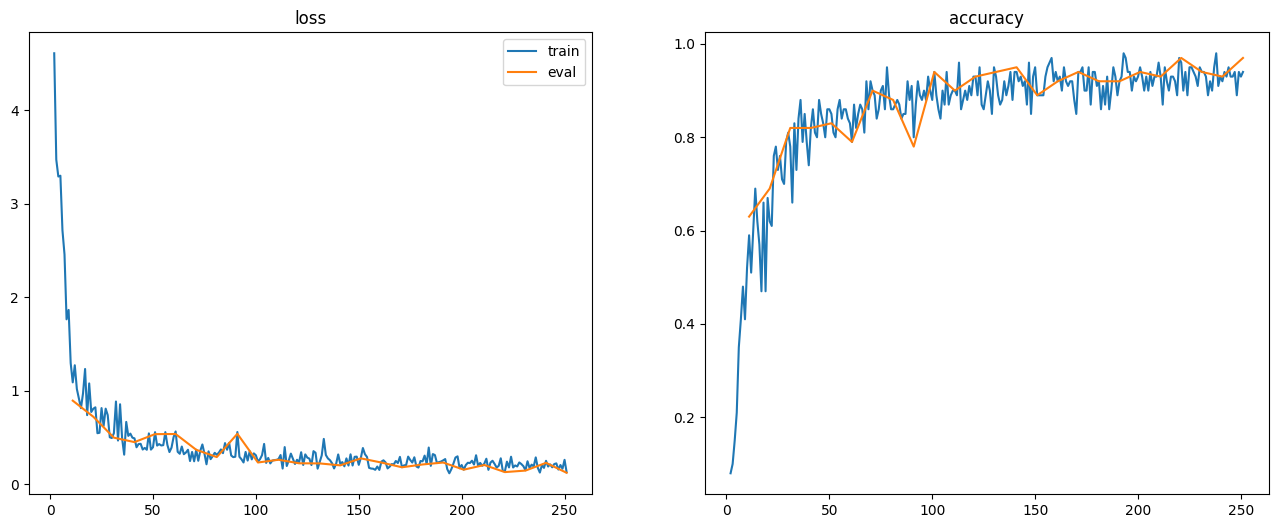

In [31]:
fix, axes = plt.subplots(1, 2, figsize=(16, 6))
for ds in ["train", "eval"]:
    for i, metric in enumerate(['loss', 'accuracy']):
        axes[i].set_title(metric)
        vals = results[ds + '_' + metric]
        x = np.array(list(map(lambda x: x[0], vals)))
        y = np.array(list(map(lambda x: x[1], vals)))
        axes[i].plot(x, y, label=ds)
axes[0].legend()

Let us compare to the curves obtained with cross entropy:

In [32]:
config.loss = cross_entropy_loss
config.optimizer = optax.adam(learning_rate=config.learning_rate)
model = CNN(num_classes=config.num_classes, dtype=jnp.float32)

init_state = create_train_state(rng, config, model, config.height, config.width)

In [33]:
results_ce, state_ce = train_and_evaluate(init_state, rng, config)

train step: 1, loss: 122.855, cross entropy: 122.855, accuracy: 13.00%
train step: 2, loss: 62.280, cross entropy: 62.280, accuracy: 15.00%
train step: 3, loss: 52.594, cross entropy: 52.594, accuracy: 5.00%
train step: 4, loss: 45.623, cross entropy: 45.623, accuracy: 20.00%
train step: 5, loss: 47.094, cross entropy: 47.094, accuracy: 17.00%
train step: 6, loss: 39.236, cross entropy: 39.236, accuracy: 28.00%
train step: 7, loss: 42.905, cross entropy: 42.905, accuracy: 28.00%
train step: 8, loss: 30.584, cross entropy: 30.584, accuracy: 35.00%
train step: 9, loss: 26.310, cross entropy: 26.310, accuracy: 44.00%
train step: 10, loss: 23.346, cross entropy: 23.346, accuracy: 43.00%
eval step: 10, loss: 20.862, cross entropy: 20.862, accuracy: 46.00%
train step: 11, loss: 21.257, cross entropy: 21.257, accuracy: 57.00%
train step: 12, loss: 23.346, cross entropy: 23.346, accuracy: 56.00%
train step: 13, loss: 19.838, cross entropy: 19.838, accuracy: 52.00%
train step: 14, loss: 10.748,

eval step: 110, loss: 2.744, cross entropy: 2.744, accuracy: 89.00%
train step: 111, loss: 1.598, cross entropy: 1.598, accuracy: 87.00%
train step: 112, loss: 1.728, cross entropy: 1.728, accuracy: 86.00%
train step: 113, loss: 2.441, cross entropy: 2.441, accuracy: 83.00%
train step: 114, loss: 2.140, cross entropy: 2.140, accuracy: 86.00%
train step: 115, loss: 2.017, cross entropy: 2.017, accuracy: 90.00%
train step: 116, loss: 0.847, cross entropy: 0.847, accuracy: 89.00%
train step: 117, loss: 2.416, cross entropy: 2.416, accuracy: 84.00%
train step: 118, loss: 2.207, cross entropy: 2.207, accuracy: 89.00%
train step: 119, loss: 1.705, cross entropy: 1.705, accuracy: 87.00%
train step: 120, loss: 3.525, cross entropy: 3.525, accuracy: 84.00%
eval step: 120, loss: 3.241, cross entropy: 3.241, accuracy: 83.00%
train step: 121, loss: 1.720, cross entropy: 1.720, accuracy: 91.00%
train step: 122, loss: 3.251, cross entropy: 3.251, accuracy: 84.00%
train step: 123, loss: 2.618, cross 

eval step: 220, loss: 0.742, cross entropy: 0.742, accuracy: 94.00%
train step: 221, loss: 1.185, cross entropy: 1.185, accuracy: 90.00%
train step: 222, loss: 1.184, cross entropy: 1.184, accuracy: 90.00%
train step: 223, loss: 0.816, cross entropy: 0.816, accuracy: 95.00%
train step: 224, loss: 0.599, cross entropy: 0.599, accuracy: 94.00%
train step: 225, loss: 0.367, cross entropy: 0.367, accuracy: 94.00%
train step: 226, loss: 0.915, cross entropy: 0.915, accuracy: 89.00%
train step: 227, loss: 1.121, cross entropy: 1.121, accuracy: 91.00%
train step: 228, loss: 1.693, cross entropy: 1.693, accuracy: 88.00%
train step: 229, loss: 1.756, cross entropy: 1.756, accuracy: 87.00%
train step: 230, loss: 0.255, cross entropy: 0.255, accuracy: 94.00%
eval step: 230, loss: 0.225, cross entropy: 0.225, accuracy: 95.00%
train step: 231, loss: 0.659, cross entropy: 0.659, accuracy: 94.00%
train step: 232, loss: 1.093, cross entropy: 1.093, accuracy: 87.00%
train step: 233, loss: 0.914, cross 

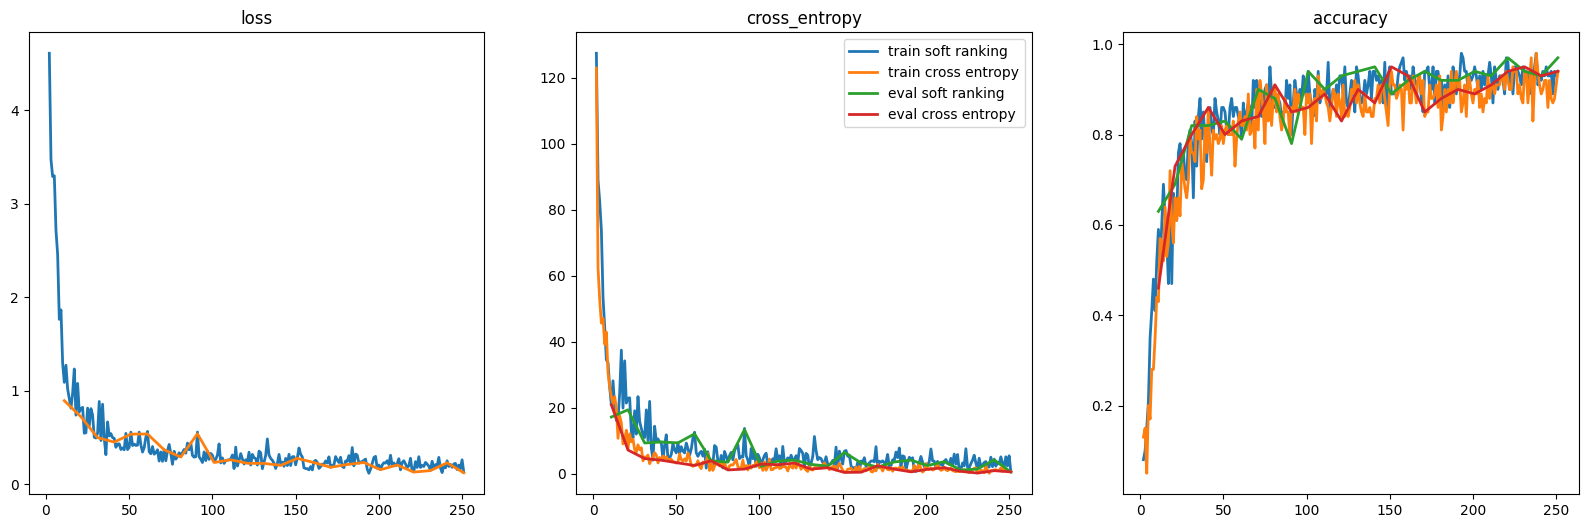

In [35]:
fix, axes = plt.subplots(1, 3, figsize=(20, 6))
for ds in ["train", "eval"]:
    for i, metric in enumerate(['loss', 'cross_entropy', 'accuracy']):
        axes[i].set_title(metric)
        vals = results[ds + '_' + metric]
        x = np.array(list(map(lambda x: x[0], vals)))
        y = np.array(list(map(lambda x: x[1], vals)))
        axes[i].plot(x, y, label=ds + ' soft ranking', linewidth=2.)
        if metric != 'loss':
            # Only plot the loss for the soft ranking training.
            vals = results_ce[ds + '_' + metric]
            x = np.array(list(map(lambda x: x[0], vals)))
            y = np.array(list(map(lambda x: x[1], vals)))
            axes[i].plot(x, y, label=ds + ' cross entropy', linewidth=2.)
axes[1].legend()